In [79]:
from io import StringIO
import pandas as pd
import numpy as np
import datetime
import time

Stock_list = pd.read_csv('name.csv')['name']
date = pd.read_csv('date.csv')['date']
Stock = pd.read_csv('model.csv')

Stock.sort_values(by=['證券代號','date'] , ascending=True, axis =0 , inplace=True)
Stock = Stock.reset_index(drop=True)

In [80]:
import math 
## 計算第 N 天後的價格差異
def day_price(df , days , list_, absolute=False, skip=None):
    for i in range(len(df)-days):
        if skip and skip(df, i): # 篩選
            continue
        price_now = df.收盤價[i]
        price_tens = df.收盤價[i+days].tolist()
        
        diff = price_tens-price_now
        if absolute: #是否不區分正負數？
            diff = abs(diff)
        
        ## by the number of * and / can modify the interval of price ratio
        rise = math.ceil((diff/price_now*100)+0.001)
        if abs(rise) > 10*days:
            continue
        list_.append(rise)    

In [81]:
def get_price_df (Stock , day , stock_list, absolute=False, skip=None):
    test_ = []
    for i in Stock_list :
        s = Stock[Stock['證券代號'] == i].reset_index(drop=True)
        day_price(s,day,test_,absolute,skip)

    # 計算方便用datframe算個數
    X = pd.DataFrame()
    X['ratio'] = test_
    
    #print(X.ratio.value_counts())
    
    # 移植數量與漲幅到新的 DF，在對漲幅sort 
    for_plt = pd.DataFrame()
    for_plt['number'] = X.ratio.value_counts().values
    for_plt['ratio'] = X.ratio.value_counts().index

    for_plt.sort_values(by=['ratio'] , ascending=True, axis =0 , inplace=True)
    for_plt = for_plt.reset_index(drop=True)
    return for_plt

In [82]:
volatility = get_price_df(Stock, 3, Stock_list, True) #波動

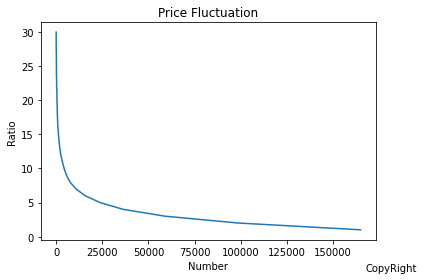

In [83]:
import matplotlib.pyplot as plt
plots = plt.plot(volatility.number, volatility.ratio)
plt.title('Price Fluctuation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.show()

# 計算Power law之常數

我們使用`scipy.optimize`的`curve_fit`的函式去逼近power law曲線，
其功能類似於least square regression。

考量兩個不同的面向：
* 逼近指數形式的(exponential)曲線
* 逼近對數形式的(logarithmic)曲線

下一個cell將先import和定義需要用到的函式、變數等，\
接著先逼近指數形式的曲線，再逼近對數形式的曲線。

（為了方便比較，兩常數以他們在對數形式的值表示）

In [84]:
# import、函式名稱即便數定義
#
#

from scipy.optimize import curve_fit

def square_error(S, T):
    '''Total square errors of the two sequences'''
    return sum([(s-t)**2 for s,t in zip(S, T)])

def power_law(x, A, gm):
    '''power law in exponential form'''
    return A*np.float_power(x, -gm)

def log_power_law(x, A, gm):
    '''power law in logarithmic form'''
    return (-gm) * x + A

X = volatility.number
Y = volatility.ratio
log_X = np.log(X)
log_Y = np.log(Y)
    

A= 4.5415983181247555 ,gamma= 0.2624739502865448
Square error (exp.): 80.09567196321021
Square error (log.): 3.3536591083634018


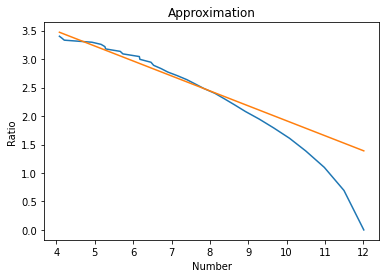

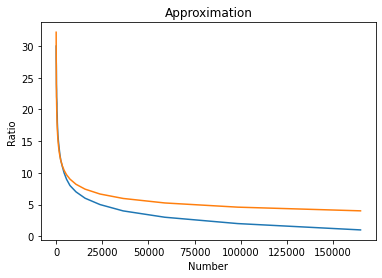

In [85]:
# 逼近指數形式的曲線
#
#

[A, gm], con = curve_fit(f=power_law, # approximate power law curve in exponential form
                        xdata=X, 
                        ydata=Y,
                        p0=[0,0])

appr_Y = [power_law(x,A,gm) for x in X]
log_appr_Y = np.log(appr_Y)


print('A=',np.log([A])[0], ',gamma=', gm) 
print("Square error (exp.):", square_error(appr_Y, Y)) # square errors in exponentail form
print("Square error (log.):", square_error(log_appr_Y, log_Y)) # square errors in logarithmic form

# plot in logarithmic form
plt.plot(log_X, log_Y)
plt.plot(log_X, log_appr_Y)
plt.title('Approximation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.show()

# plot in exponential form
plt.plot(X,Y)
plt.plot(X, appr_Y)
plt.title('Approximation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.show()

A= 5.2030849763086655 ,gamma= 0.3675949039967035
Square error (exp.): 403.1457149405338
Square error (log.): 1.3539895700068438


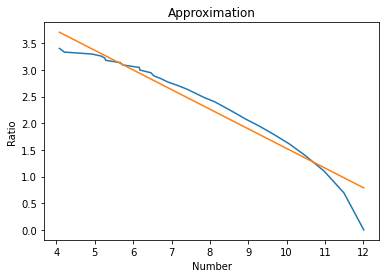

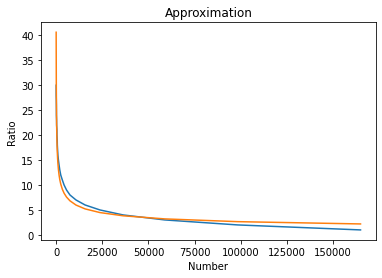

In [86]:
# 逼近對數形式的(logarithmic)曲線
#
#


[A, gm], con = curve_fit(f=log_power_law, # approximate logarithmically
                        xdata=log_X, 
                        ydata=log_Y,
                        p0=[0,0])

log_appr_Y = [log_power_law(x,A,gm) for x in log_X]

print('A=',A, ',gamma=', gm)
print("Square error (exp.):", square_error(np.exp(log_appr_Y), Y)) # square errors in the exponentail form
print("Square error (log.):", square_error(log_appr_Y, log_Y)) # square errors in the logarithmic form

# plot in logarithmic form
plt.plot(log_X, log_Y)
plt.plot(log_X, log_appr_Y)
plt.title('Approximation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.show()

# plot in exponential form
plt.plot(X,Y)
plt.plot(X,np.exp(log_appr_Y))
plt.title('Approximation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.show()

## Plot rise part

In [87]:
import math
ratio_log = []
number_log = []
for_plt = get_price_df (Stock , 3 , Stock_list, False) #取出不區分正負數的資料
# 對數量、震幅取log
for i in range(len(for_plt.ratio)):
    if for_plt.ratio[i] > 0: 
        ratio_log.append(math.log(for_plt.ratio[i],10))
        number_log.append(math.log(for_plt.number[i],10))
        

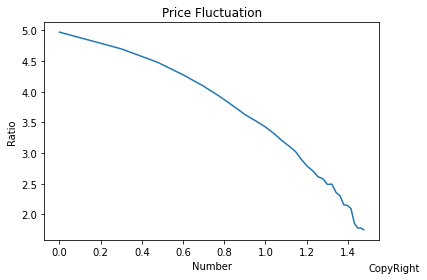

In [88]:
import matplotlib.pyplot as plt
plots = plt.plot(ratio_log, number_log)
plt.title('Price Fluctuation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.show()

## Plot drop part

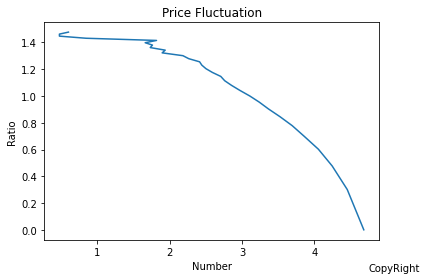

In [89]:
import math
drop_ratio_log = []
drop_number_log = []
for i in range(len(for_plt.ratio)):
    # 震幅 < 0 ，代表下跌
    if for_plt.ratio[i] < 0: 
        drop_ratio_log.append(math.log(-for_plt.ratio[i],10))
        drop_number_log.append(math.log(for_plt.number[i],10))

plots = plt.plot(drop_number_log, drop_ratio_log)
plt.title('Price Fluctuation')
plt.xlabel('Number')
plt.ylabel('Ratio')
plt.figtext(0.995, 0.01, 'CopyRight', ha='right', va='bottom')
plt.show()

Text(0.5, 1.0, 'Rise vs Fall ')

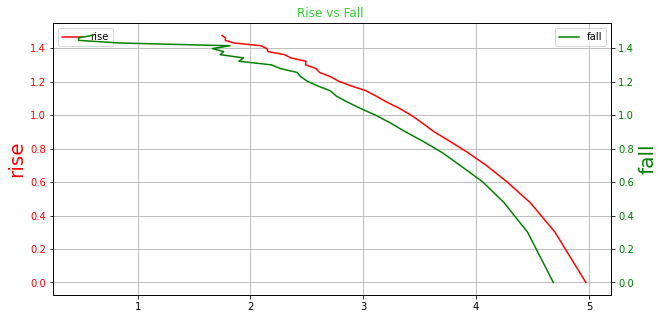

In [90]:
## 繪製重疊圖，方便漲跌比對

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(number_log, ratio_log,color='red',label='rise')
ax.set_ylabel('rise',color='red',fontsize=20)
ax.tick_params(axis='y',labelcolor='red')
plt.grid()
ax.legend(loc='upper left')

ax2=ax.twinx()
ax2.plot(drop_number_log, drop_ratio_log,color='green',label='fall')
ax2.set_ylabel('fall',color='green',fontsize=20)
ax2.tick_params(axis='y',labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Rise vs Fall ', color='limegreen')


In [91]:
## 設定股票篩選的條件，技術、籌碼指標大概都試過了，沒甚麼用

def skip(df, i):
    if df['MA5 slope'][i] < 0 :
            return True
    elif df['UD60'][i] <= 0.05 :
            return True
    elif df['連漲跌'][i] >= 3 or  df['連漲跌'][i] <= 0:
            return True
    elif df['均線糾結1'][i] == 0 :
            return True
    elif df['成交金額'][i] < 300000000 :
        return True
    
    return False

In [92]:
for_plt = get_price_df (Stock , 3 , Stock_list, skip=skip)

In [93]:
ratio_log = []
number_log = []
for i in range(len(for_plt.ratio)):
    if for_plt.ratio[i] > 0: 
        ratio_log.append(math.log(for_plt.ratio[i],10))
        number_log.append(math.log(for_plt.number[i],10))
drop_ratio_log = []
drop_number_log = []
for i in range(len(for_plt.ratio)):
    if for_plt.ratio[i] < 0: 
        drop_ratio_log.append(math.log(-for_plt.ratio[i],10))
        drop_number_log.append(math.log(for_plt.number[i],10))

Text(0.5, 1.0, 'Rise vs Fall ')

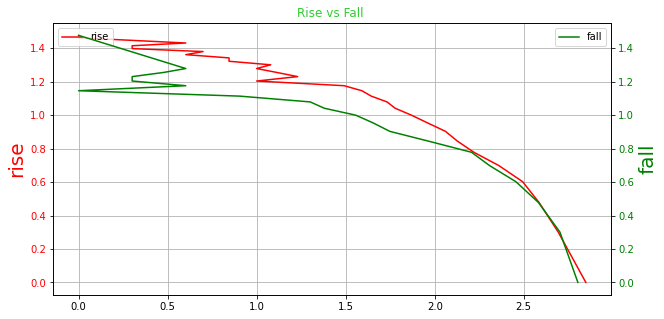

In [94]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(number_log, ratio_log,color='red',label='rise')
ax.set_ylabel('rise',color='red',fontsize=20)
ax.tick_params(axis='y',labelcolor='red')
plt.grid()
ax.legend(loc='upper left')

ax2=ax.twinx()
ax2.plot(drop_number_log, drop_ratio_log,color='green',label='fall')
ax2.set_ylabel('fall',color='green',fontsize=20)
ax2.tick_params(axis='y',labelcolor='green')
ax2.legend(loc='upper right')
plt.title('Rise vs Fall ', color='limegreen')
